In [11]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.autograd as auto
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import librosa
import matplotlib.pyplot as plt

In [2]:
data=joblib.load('mfcc.sav')
len(data)

X,y=[],[]
for i in data:
    X.append(librosa.util.pad_center(i[0], 173, axis=1))
    y.append(i[1])

y_dictionary={'air_conditioner':0,
              'car_horn':1,
              'children_playing':2,
              'dog_bark':3,
              'drilling':4,
              'engine_idling':5,
              'gun_shot':6,
              'jackhammer':7,
              'siren':8,
              'street_music':9}

for i in range(0,len(y)):
#     print(y[i],'-->',y_dictionary.get(y[i]),'==>',end='')
    y[i]=y_dictionary.get(y[i])
#     print(y[i])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train[2].shape

(40, 173)

In [5]:
BATCH_SIZE = 64

In [6]:
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.Tensor(y_train)
y_test=torch.Tensor(y_test)

In [7]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE * 2)

In [12]:
# parameters 
N_STEPS = 40
N_INPUTS = 173
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 20

In [13]:
class SoundRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(SoundRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SoundRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [15]:
for_plot_loss=[]
for_plot_acc=[]
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        model.hidden = model.init_hidden() 
        
        inputs, labels = data
        inputs = inputs.view(-1, 40,173) 
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels.long(), BATCH_SIZE)
        
    for_plot_loss.append(train_running_loss/i)
    for_plot_acc.append(train_acc/i)    
        
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 2.2982 | Train Accuracy: 16.01
Epoch:  1 | Loss: 2.0437 | Train Accuracy: 28.34
Epoch:  2 | Loss: 1.8784 | Train Accuracy: 36.58
Epoch:  3 | Loss: 1.7246 | Train Accuracy: 43.97
Epoch:  4 | Loss: 1.5737 | Train Accuracy: 51.54
Epoch:  5 | Loss: 1.4214 | Train Accuracy: 57.34
Epoch:  6 | Loss: 1.3068 | Train Accuracy: 62.58
Epoch:  7 | Loss: 1.1904 | Train Accuracy: 66.12
Epoch:  8 | Loss: 1.0401 | Train Accuracy: 73.13
Epoch:  9 | Loss: 0.9195 | Train Accuracy: 77.00
Epoch:  10 | Loss: 0.9125 | Train Accuracy: 77.27
Epoch:  11 | Loss: 0.8136 | Train Accuracy: 80.25
Epoch:  12 | Loss: 0.6649 | Train Accuracy: 86.37
Epoch:  13 | Loss: 0.5797 | Train Accuracy: 89.57
Epoch:  14 | Loss: 0.5327 | Train Accuracy: 91.06
Epoch:  15 | Loss: 0.5119 | Train Accuracy: 90.60
Epoch:  16 | Loss: 0.4121 | Train Accuracy: 94.58
Epoch:  17 | Loss: 0.3432 | Train Accuracy: 96.00
Epoch:  18 | Loss: 0.2919 | Train Accuracy: 97.39
Epoch:  19 | Loss: 0.2573 | Train Accuracy: 97.94


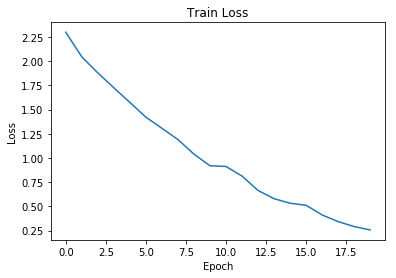

In [16]:
plt.plot(for_plot_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Train Loss")
plt.show()

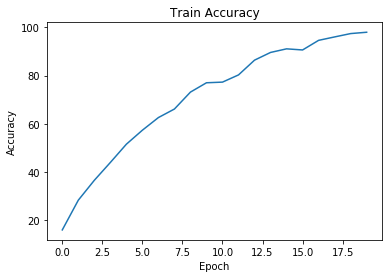

In [17]:
plt.plot(for_plot_acc)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Train Accuracy")
plt.show()